# DV_Final_Project_Part3

Group Name: SSSL
Group Member: Jiaxin Song, Chaohan Shang, Yun Sun, Weihao Li.

In [1]:
%matplotlib inline

In [2]:
import re
import collections
import bqplot
import numpy as np
import ipywidgets
import seaborn as sns
import pandas as pd
from bqplot import *
import matplotlib.pyplot as plt

In [3]:
# plotly.tools.set_credentials_file(username='Jiaxins2', api_key='WEsQb8U99ZjFhm515YU0')

In [4]:
data = pd.read_excel("DV_Dataset.xlsx")
data.describe()

,Incident,Date reported,Time reported,Date occurred,Time occurred,General Location,Crime Description,Disposition
count,4607,4607,4607,4607,4607,4607,4607,4607
unique,3841,402,1051,640,927,1296,288,15
top,UU1705578,2017-03-14 00:00:00,0:00,2017-03-03 00:00:00,UNKNOWN,RED LION,UNLAWFUL USE OF I.D.,REPORTED TO OTHER AGENCY
freq,11,124,1929,49,213,281,412,1972
first,NaN,2017-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,2018-03-14 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
collections.Counter(data["Disposition"])

Counter({'ADMIN CLOSED': 958,
         'ADMIN. CLOSE': 442,
         'ARREST': 545,
         'CLEARED EXCEPT. JUVENILE NO CU': 2,
         'CLEARED EXCEPT. PROS. FAIL TO': 8,
         'CLEARED EXCEPT. REFUSAL TO COO': 4,
         'PENDING': 219,
         'REFERRED TO OTHER JURISDICTION': 5,
         'REPORTED TO OTHER AGENCY': 1972,
         'STUDENT DISC REFERRAL': 222,
         'STUDENT DISCIPLINE': 137,
         'STUDENT DISCIPLINE REFERRAL': 59,
         'UNFOUNDED': 32,
         'WARNING (TRAFFIC)': 1,
         'unk': 1})

In [6]:
# Unify the name of disposition type

In [7]:
data["Disposition"]=data['Disposition'].replace(["ADMIN. CLOSE", "ADMIN CLOSED"], "ADMIN.CLOSED")
data["Disposition"]=data['Disposition'].replace(["STUDENT DISCIPLINE","STUDENT DISC REFERRAL"], "STUDENT DISCIPLINE REFERRAL")
collections.Counter(data["Disposition"])

Counter({'ADMIN.CLOSED': 1400,
         'ARREST': 545,
         'CLEARED EXCEPT. JUVENILE NO CU': 2,
         'CLEARED EXCEPT. PROS. FAIL TO': 8,
         'CLEARED EXCEPT. REFUSAL TO COO': 4,
         'PENDING': 219,
         'REFERRED TO OTHER JURISDICTION': 5,
         'REPORTED TO OTHER AGENCY': 1972,
         'STUDENT DISCIPLINE REFERRAL': 418,
         'UNFOUNDED': 32,
         'WARNING (TRAFFIC)': 1,
         'unk': 1})

The pending case is the 219/4607th of the total case.

In [8]:
Disposition = pd.DataFrame(data['Disposition'].value_counts().reset_index())
Disposition.columns = ['Disposition', 'count']

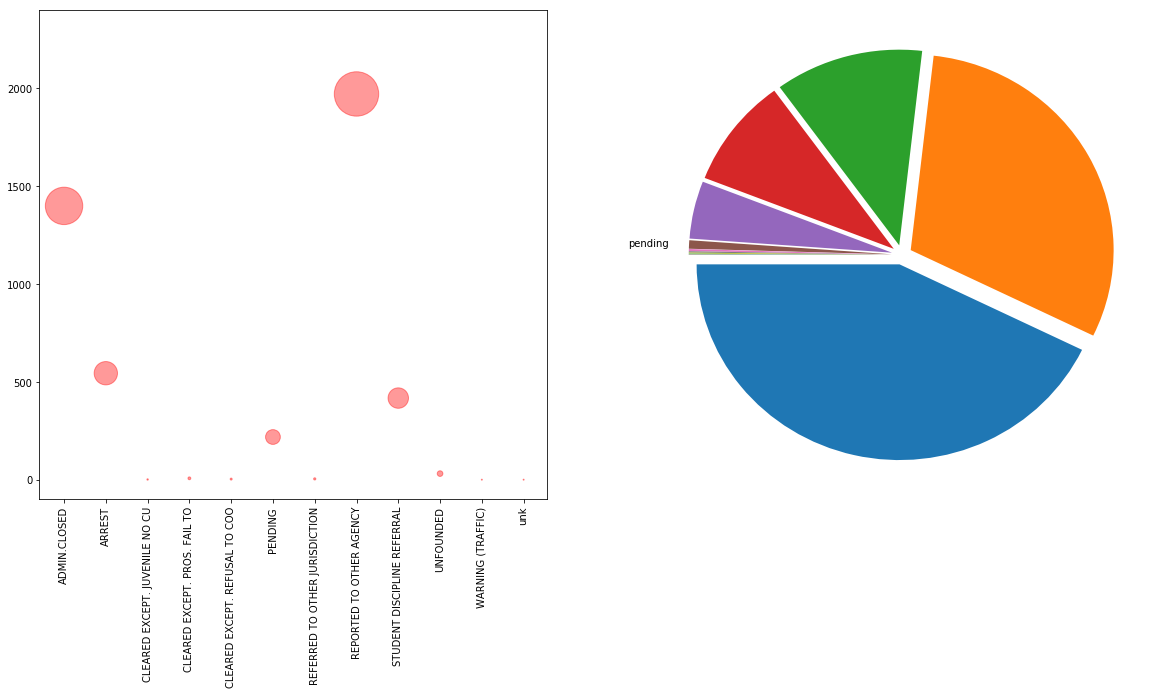

In [9]:
plt.figure(figsize=(20,9))
plt.subplot(121)
plt.xticks(rotation=90)
plt.ylim(-100,2400)
plt.scatter(Disposition["Disposition"], y = Disposition["count"],s=Disposition["count"]*1,c="red", alpha=0.4)
plt.subplot(122)
fig=plt.pie(Disposition["count"], explode=0.05 * np.ones(12), startangle=180,labels=['','','','','','pending','','','','','',''])[0]

# Classify the location into outdoor and indoor location

We use the regex to filter the 'General Location' column and divide it into two categories: Indoor & Outdoor.
In this procedure, we determine if the column contains the following characters: 'ST','DR','AV','AVE','E','N','W','S'.
For those who meet the requirements, we replace the location with 'Outside' and vice versa.

In [10]:
def location_sort(location):
    # We add one column to show the status of each incident.
    status = []
    crime = data["Crime Description"]
    st = r' ST| DR| AV| AVE| E | N | W | S |'
    Outside = 0
    Indoor = 0
    for i in range(len(location)):
        if len(set(re.findall(st,location[i])))==1:
            status.append("Outside")
            Outside +=1
        else:
            Indoor +=1
            status.append("Indoor")
    status = pd.DataFrame(status)
    result = pd.concat([location, crime, status], axis=1)
    result.columns = ['Location','Crime Description','Status']
    return result
In_N_Out = location_sort(data["General Location"])

In [11]:
# Divide the entire dataset into two parts: indoor data and outdoor data.
in_data = []
ot_data = []
for i in range(len(In_N_Out)):
    if In_N_Out['Status'][i] == 'Indoor':
        in_data.append(In_N_Out['Crime Description'][i])
    else:
        ot_data.append(In_N_Out['Crime Description'][i])
in_data = pd.DataFrame({'Crime Description':in_data})
ot_data = pd.DataFrame({'Crime Description':ot_data})

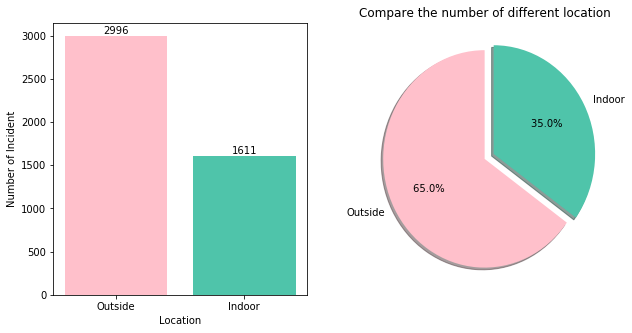

In [12]:
# Check the indoor and outdoor location's proportion with bar chart and pie chart.
outnum = 0
innum = 0
for i in range(len(In_N_Out['Status'])):
    if In_N_Out['Status'][i] == 'Outside':
        outnum += 1
    else:
        innum += 1
name_list = ['Outside','Indoor']  
num_list = [outnum, innum] 

fig=plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(1,2,1)
x = range(len(num_list))
y=num_list
color_list=['pink','#4fc4aa']
ax1.bar(x, y,color=color_list,tick_label=name_list)  
ax1.set_xlabel('Location') 
ax1.set_ylabel('Number of Incident') 
for a,b in zip(x,y):
    ax1.text(a, b+0.05, '%.0f' % b, ha='center', va= 'bottom',fontsize=10)
ax2 = fig.add_subplot(1,2,2)
labels = 'Outside','Indoor'
fracs = [outnum, innum]
explode = [0,0.1]
ax2.pie(x=fracs, labels=labels, explode=explode,autopct='%3.1f%% ',colors=color_list,
        shadow=True, labeldistance=1.1, startangle = 90,pctdistance = 0.6)
plt.title('Compare the number of different location')
plt.show()

# Classify Crime Description into 9 categories.

By filtering the crime description, we normalize them into 9 types and rename them with standard tags.
We use a function named crime_type_sort to accomplish this complementation.

In [13]:
# DV for crime types
crime_1 = r'LIQUOR|ALCOHOL'
crime_2 = r'THEFT|FRAUD|STOLEN|ROBBERY|PROPERTY|BURGLARY'
crime_3 = r'DRUGS|CANNABIS|HEROIN'
crime_4 = r'BATTERY|VIOLENCE|FIGHTING'
crime_5 = r'SEX|SEXUAL|RAGE|ASSUALT'
crime_6 = r'HARASSMENT|STALKING'
crime_7 = r'SUICIDE'
crime_8 = r'WEAPON|ARMED|FOID'
crime_9 = r'I.D.'

def crime_type_sort(crime_type):  
    
    alcohol_related = 0
    property_related = 0
    drugs_related = 0
    violence_related = 0
    sexual_related = 0
    harassment_related = 0
    suicide = 0
    weapon_related = 0
    id_related = 0
    
    for i in range(len(crime_type)):
        crime_type[i].upper()
        if len(re.findall(crime_1,crime_type[i])) >= 1:
            alcohol_related +=1
        if len(re.findall(crime_2,crime_type[i])) >= 1:
            property_related +=1
        if len(re.findall(crime_3,crime_type[i])) >= 1:
            drugs_related +=1
        if len(re.findall(crime_4,crime_type[i])) >= 1:
            violence_related +=1
        if len(re.findall(crime_5,crime_type[i])) >= 1:
            sexual_related +=1
        if len(re.findall(crime_6,crime_type[i])) >= 1:
            harassment_related +=1
        if len(re.findall(crime_7,crime_type[i])) >= 1:
            suicide +=1
        if len(re.findall(crime_8,crime_type[i])) >= 1:
            weapon_related +=1
        if len(re.findall(crime_9,crime_type[i])) >= 1:
            id_related +=1
    return(alcohol_related,property_related,drugs_related,
          violence_related,sexual_related,harassment_related,
          suicide,weapon_related,id_related)

In [14]:
#use stack chart to compare the crimes types respect to indoor and outdoor
critypes = ['alcohol','property','drugs','violence','sexual','harassment','suicide','weapon','id']
x_sc = OrdinalScale(domain=critypes)
y_sc = LinearScale()
#x_data = np.arange(len(critypes))
y_in = np.array(crime_type_sort(in_data['Crime Description']))
y_out = np.array(crime_type_sort(ot_data['Crime Description']))

def_tt = Tooltip(fields=['y'],labels=['Number'])
bar_chart = Bars(x=critypes, y=[y_in.tolist(),y_out.tolist()], scales= {'x': x_sc, 'y': y_sc},
                 colors=['#6699CC','pink'],
                 labels=['Indoor', 'Outside'],tooltip=def_tt,
                 display_legend=True)

ax_x = Axis(label='Crime Type',scale=x_sc)
ax_y = Axis(label='Number of Crimes',scale=y_sc, orientation='vertical')

Figure(marks=[bar_chart], axes=[ax_x, ax_y],title='Compare the crime types of outside and indoor')

Figure(axes=[Axis(label='Crime Type', scale=OrdinalScale(domain=['alcohol', 'property', 'drugs', 'violence', 'sexual', 'harassment', 'suicide', 'weapon', 'id'])), Axis(label='Number of Crimes', orientation='vertical', scale=LinearScale())], fig_margin={'top': 60, 'bottom': 60, 'left': 60, 'right': 60}, layout=Layout(min_width='125px'), marks=[Bars(colors=['#6699CC', 'pink'], display_legend=True, interactions={'hover': 'tooltip'}, labels=['Indoor', 'Outside'], scales={'x': OrdinalScale(domain=['alcohol', 'property', 'drugs', 'violence', 'sexual', 'harassment', 'suicide', 'weapon', 'id']), 'y': LinearScale()}, scales_metadata={'x': {'orientation': 'horizontal', 'dimension': 'x'}, 'y': {'orientation': 'vertical', 'dimension': 'y'}, 'color': {'dimension': 'color'}}, tooltip=Tooltip(fields=['y'], labels=['Number']), tooltip_style={'opacity': 0.9}, x=array(['alcohol', 'property', 'drugs', 'violence', 'sexual', 'harassment',
       'suicide', 'weapon', 'id'], dtype='<U10'), y=array([[177, 550,  85, 127, 115,  18,  36,  19,  18],
       [475, 604, 389, 125, 398, 109,   4,   8, 401]]))], scale_x=LinearScale(allow_padding=False, max=1.0, min=0.0), scale_y=LinearScale(allow_padding=False, max=1.0, min=0.0), title='Compare the crime types of outside and indoor')

# Occurred time VS Crime Description

In [15]:
# Extract the hour from the occurred time column 

In [16]:
time_occurred=[]
match_type = '\d+(?=:)'
for i in range(len(data["Time occurred"])):
            time_occurred.append(re.findall(match_type,data['Time occurred'][i]))
time_occurred= pd.DataFrame(time_occurred)    
time_crime = pd.concat([time_occurred,data['Crime Description'],data['General Location']], axis=1)
time_crime.columns=["Hour",'Crime Description','General Location']

In [17]:
time_crime=time_crime.dropna(axis=0, how='any').reset_index(level=None,drop=True)

In [18]:
# Divide the time into three periods.
# period1: 21:00 - 3:00
# period2: 3:00 - 12:00
# period3: 12:00 - 21:00

In [19]:
period1=[]
period2 =[]
period3 =[]
index1 = []
index2 = []
index3 = []
for i in range (len(time_crime['Hour'])):
    if int(time_crime['Hour'][i]) > 21 or int(time_crime['Hour'][i]) <= 3:
                                    period1.append(time_crime['Hour'][i])
                                    index1.append(i)
    if int(time_crime['Hour'][i]) > 3 and int(time_crime['Hour'][i]) <= 12:
                                    period2.append(time_crime['Hour'][i])
                                    index2.append(i)
    if int(time_crime['Hour'][i]) > 12 and int(time_crime['Hour'][i]) <= 21:
                                    period3.append(time_crime['Hour'][i])
                                    index3.append(i)
period1 = pd.DataFrame(period1) 
period2 = pd.DataFrame(period2) 
period3 = pd.DataFrame(period3) 

In [20]:
# Classify the Crime Description repect to the three time periods.

In [21]:
crime1 = []
for i in range(len(index1)):
    crime1.append(time_crime["Crime Description"][i])
crime2 = []
for i in range(len(index2)):
    crime2.append(time_crime["Crime Description"][i])
crime3 = []
for i in range(len(index3)):
    crime3.append(time_crime["Crime Description"][i])
crime1 = pd.DataFrame(crime1) 
crime2 = pd.DataFrame(crime2) 
crime3 = pd.DataFrame(crime3) 

In [22]:
# Create a new dataframe which includes the time(hour) column and Crime Description.

In [23]:
result1 = pd.concat([period1,crime1], axis=1)
result1.columns=["Hour",'Crime Description']
result2 = pd.concat([period2,crime2], axis=1)
result2.columns=["Hour",'Crime Description']
result3 = pd.concat([period3,crime3], axis=1)
result3.columns=["Hour",'Crime Description']

# Occurred time VS General Location

In [24]:
location1 = []
for i in range(len(index1)):
    location1.append(time_crime["General Location"][i])
location2 = []
for i in range(len(index2)):
    location2.append(time_crime["General Location"][i])
location3 = []
for i in range(len(index3)):
    location3.append(time_crime["General Location"][i])
location1 = pd.DataFrame(location1) 
location2 = pd.DataFrame(location2) 
location3 = pd.DataFrame(location3) 

In [25]:
time_location1= pd.concat([period1,location1], axis=1)
time_location1.columns=["Hour",'General Location']
time_location2 = pd.concat([period2,location2], axis=1)
time_location2.columns=["Hour",'General Location']
time_location3 = pd.concat([period3,location3], axis=1)
time_location3.columns=["Hour",'General Location']

In [26]:
# Analyze the incidents which are reported in one day.

In [27]:
time_series = pd.DataFrame(data['Date reported'].value_counts().reset_index())
time_series.columns = ['date', 'count']
new_ts = time_series.sort_values(by = ['date'])

In [28]:
# Adding default tooltip to Line Chart
x_sc = DateScale()
y_sc = LinearScale()
x_data = new_ts['date']
y_data = new_ts['count']
def_tt = Tooltip(fields = ['color', 'name'], labels = ['Date', 'Count'])
line_chart = Lines(x = x_data, y = y_data, scales = {'x': x_sc, 'y': y_sc}, 
                       tooltip = def_tt, display_legend = True, labels = ["Crime numbers"])
line_chart.colors = ['#66b3ff']
ax_x = Axis(label = 'Date', scale = x_sc, grid_lines='dashed')
ax_y = Axis(label = 'Number', scale = y_sc, orientation = 'vertical')
pz = interacts.PanZoom( scales = {'x': [x_sc], 'y': [y_sc]} )

fig = Figure(title = "Crime numbers per day", marks = [line_chart], axes = [ax_x, ax_y], linestyle = 'solid',
       legend_location='top-right',fig_margin = dict(left=50, right=10, top=50, bottom=50), interaction = pz)
display(fig)

Figure(axes=[Axis(grid_lines='dashed', label='Date', scale=DateScale()), Axis(label='Number', orientation='vertical', scale=LinearScale())], fig_margin={'left': 50, 'right': 10, 'top': 50, 'bottom': 50}, interaction=PanZoom(scales={'x': [DateScale()], 'y': [LinearScale()]}), layout=Layout(min_width='125px'), marks=[Lines(colors=['#66b3ff'], display_legend=True, interactions={'hover': 'tooltip'}, labels=['Crime numbers'], scales={'x': DateScale(), 'y': LinearScale()}, scales_metadata={'x': {'orientation': 'horizontal', 'dimension': 'x'}, 'y': {'orientation': 'vertical', 'dimension': 'y'}, 'color': {'dimension': 'color'}}, tooltip=Tooltip(fields=['color', 'name'], labels=['Date', 'Count']), tooltip_style={'opacity': 0.9}, x=array(['2017-01-01T00:00:00.000000000', '2017-01-03T00:00:00.000000000',
       '2017-01-04T00:00:00.000000000', '2017-01-05T00:00:00.000000000',
       '2017-01-08T00:00:00.000000000', '2017-01-09T00:00:00.000000000',
       '2017-01-10T00:00:00.000000000', '2017-01-11T00:00:00.000000000',
       '2017-01-12T00:00:00.000000000', '2017-01-13T00:00:00.000000000',
       '2017-01-14T00:00:00.000000000', '2017-01-15T00:00:00.000000000',
       '2017-01-16T00:00:00.000000000', '2017-01-17T00:00:00.000000000',
       '2017-01-18T00:00:00.000000000', '2017-01-19T00:00:00.000000000',
       '2017-01-20T00:00:00.000000000', '2017-01-21T00:00:00.000000000',
       '2017-01-22T00:00:00.000000000', '2017-01-23T00:00:00.000000000',
       '2017-01-24T00:00:00.000000000', '2017-01-25T00:00:00.000000000',
       '2017-01-26T00:00:00.000000000', '2017-01-27T00:00:00.000000000',
       '2017-01-28T00:00:00.000000000', '2017-01-29T00:00:00.000000000',
       '2017-01-30T00:00:00.000000000', '2017-01-31T00:00:00.000000000',
       '2017-02-01T00:00:00.000000000', '2017-02-02T00:00:00.000000000',
       '2017-02-03T00:00:00.000000000', '2017-02-04T00:00:00.000000000',
       '2017-02-05T00:00:00.000000000', '2017-02-06T00:00:00.000000000',
       '2017-02-07T00:00:00.000000000', '2017-02-08T00:00:00.000000000',
       '2017-02-09T00:00:00.000000000', '2017-02-10T00:00:00.000000000',
       '2017-02-11T00:00:00.000000000', '2017-02-12T00:00:00.000000000',
       '2017-02-13T00:00:00.000000000', '2017-02-14T00:00:00.000000000',
       '2017-02-15T00:00:00.000000000', '2017-02-16T00:00:00.000000000',
       '2017-02-17T00:00:00.000000000', '2017-02-18T00:00:00.000000000',
       '2017-02-19T00:00:00.000000000', '2017-02-20T00:00:00.000000000',
       '2017-02-21T00:00:00.000000000', '2017-02-22T00:00:00.000000000',
       '2017-02-23T00:00:00.000000000', '2017-02-24T00:00:00.000000000',
       '2017-02-25T00:00:00.000000000', '2017-02-26T00:00:00.000000000',
       '2017-02-27T00:00:00.000000000', '2017-02-28T00:00:00.000000000',
       '2017-03-01T00:00:00.000000000', '2017-03-02T00:00:00.000000000',
       '2017-03-03T00:00:00.000000000', '2017-03-04T00:00:00.000000000',
       '2017-03-05T00:00:00.000000000', '2017-03-06T00:00:00.000000000',
       '2017-03-07T00:00:00.000000000', '2017-03-08T00:00:00.000000000',
       '2017-03-09T00:00:00.000000000', '2017-03-10T00:00:00.000000000',
       '2017-03-11T00:00:00.000000000', '2017-03-12T00:00:00.000000000',
       '2017-03-13T00:00:00.000000000', '2017-03-14T00:00:00.000000000',
       '2017-03-15T00:00:00.000000000', '2017-03-16T00:00:00.000000000',
       '2017-03-17T00:00:00.000000000', '2017-03-18T00:00:00.000000000',
       '2017-03-19T00:00:00.000000000', '2017-03-21T00:00:00.000000000',
       '2017-03-23T00:00:00.000000000', '2017-03-25T00:00:00.000000000',
       '2017-03-26T00:00:00.000000000', '2017-03-27T00:00:00.000000000',
       '2017-03-28T00:00:00.000000000', '2017-03-29T00:00:00.000000000',
       '2017-03-30T00:00:00.000000000', '2017-03-31T00:00:00.000000000',
       '2017-04-01T00:00:00.000000000', '2017-04-02T00:00:00.000000000',
       '2017-04-03T00:00:00.000000000', '2017-04-04T00:00:00.000000000',
       '2017-04-05T00:00:00.000000000', '2017-04-06T00:0

In [29]:
# Analyze the likelihood of an incident reported in each hour.

In [30]:
hour_series = pd.DataFrame(time_crime['Hour'].value_counts().reset_index())
hour_series.columns = ['hour', 'count']
hour_series["hour"] = hour_series["hour"].astype(int)
hour_series["count"] = hour_series["count"].apply(lambda x: x/439200*100)
new_hs = hour_series.sort_values(by = ['hour'])

In [31]:
x_sc = LinearScale()
y_sc = LinearScale()
x_data = new_hs['hour']
y_data = new_hs['count']
tt = Tooltip(fields = ['x', 'y'], formats=['', '.2f'], labels = ['Hour', 'Percent'])
scatters =Scatter(x = new_hs['hour'], y = new_hs['count'], scales = {'x': x_sc, 'y': y_sc},
                          sizes = 0.5, tooltip = tt, colors = ['green'])

line_chart = Lines(x = x_data, y = y_data, scales = {'x': x_sc, 'y': y_sc}, 
                     display_legend = True, labels = ["Crime distribution in each hour"])
line_chart.colors = ['#33bb33']
ax_x = Axis(label = 'Hour', scale = x_sc, grid_lines='dashed')
ax_y = Axis(label = 'Crime_percent', scale = y_sc, tick_format='0.2f', orientation = 'vertical')
ls = interacts.LassoSelector(scales = {'x': x_sc, 'y': y_sc},
                                   marks = [line_chart])
fig = Figure(title = "Crime numbers per day", marks = [line_chart, scatters], axes = [ax_x, ax_y], linestyle = 'solid',
       legend_location='top',fig_margin = dict(left=50, right=2, top=50, bottom=50))
label = ipywidgets.Label()
display(fig, label)

Figure(axes=[Axis(grid_lines='dashed', label='Hour', scale=LinearScale()), Axis(label='Crime_percent', orientation='vertical', scale=LinearScale(), tick_format='0.2f')], fig_margin={'left': 50, 'right': 2, 'top': 50, 'bottom': 50}, layout=Layout(min_width='125px'), legend_location='top', marks=[Lines(colors=['#33bb33'], display_legend=True, interactions={'hover': 'tooltip'}, labels=['Crime distribution in each hour'], scales={'x': LinearScale(), 'y': LinearScale()}, scales_metadata={'x': {'orientation': 'horizontal', 'dimension': 'x'}, 'y': {'orientation': 'vertical', 'dimension': 'y'}, 'color': {'dimension': 'color'}}, tooltip_style={'opacity': 0.9}, x=array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23]), y=array([0.12682149, 0.08469945, 0.06147541, 0.02163024, 0.01593807,
       0.00705829, 0.01001821, 0.00751366, 0.02026412, 0.0170765 ,
       0.01593807, 0.02117486, 0.04257741, 0.02140255, 0.03415301,
       0.03210383, 0.03620219, 0.03984517, 0.04690346, 0.03893443,
       0.04417122, 0.05874317, 0.08151184, 0.11384335])), Scatter(colors=['green'], interactions={'hover': 'tooltip'}, scales={'x': LinearScale(), 'y': LinearScale()}, scales_metadata={'x': {'orientation': 'horizontal', 'dimension': 'x'}, 'y': {'orientation': 'vertical', 'dimension': 'y'}, 'color': {'dimension': 'color'}, 'size': {'dimension': 'size'}, 'opacity': {'dimension': 'opacity'}, 'rotation': {'dimension': 'rotation'}, 'skew': {'dimension': 'skew'}}, tooltip=Tooltip(fields=['x', 'y'], formats=['', '.2f'], labels=['Hour', 'Percent']), tooltip_style={'opacity': 0.9}, x=array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23]), y=array([0.12682149, 0.08469945, 0.06147541, 0.02163024, 0.01593807,
       0.00705829, 0.01001821, 0.00751366, 0.02026412, 0.0170765 ,
       0.01593807, 0.02117486, 0.04257741, 0.02140255, 0.03415301,
       0.03210383, 0.03620219, 0.03984517, 0.04690346, 0.03893443,
       0.04417122, 0.05874317, 0.08151184, 0.11384335]))], scale_x=LinearScale(allow_padding=False, max=1.0, min=0.0), scale_y=LinearScale(allow_padding=False, max=1.0, min=0.0), title='Crime numbers per day')

Label(value='')

In [32]:
# Interaction for time period vs general location.

In [33]:
time_location_count1=pd.DataFrame(time_location1["General Location"].value_counts().reset_index())
time_location_count1.columns = ['General Location', 'Count']
time_location_count2=pd.DataFrame(time_location2["General Location"].value_counts().reset_index())
time_location_count2.columns = ['General Location', 'Count']
time_location_count3=pd.DataFrame(time_location3["General Location"].value_counts().reset_index())
time_location_count3.columns = ['General Location', 'Count']

In [34]:
@ipywidgets.interact(time_location = ['period1: 21:00-3:00','period2: 3:00-12:00','period3: 12:00-21:00'],)
def print_bandname(time_location):
    
    x_sc = bqplot.OrdinalScale()
    y_sc = bqplot.LinearScale()

    x_ax = bqplot.Axis(scale = x_sc, label = 'General Location')
    y_ax = bqplot.Axis(scale = y_sc, label = 'Count', orientation = 'vertical')
    tt = bqplot.Tooltip(fields = ["x","y"], labels=["General Location","Crimes"])
    label = ipywidgets.Label()
    
    if time_location=='period1: 21:00-3:00':
        scatters = bqplot.Scatter(x = time_location_count1["General Location"],
                          y=time_location_count1["Count"], scales = {'x': x_sc, 'y': y_sc},
                          sizes = 10, tooltip = tt, colors=['dodgerblue'])
        fig = bqplot.Figure(marks = [scatters], axes = [y_ax],interaction = None)
        display(fig, label);
        
    if time_location=='period2: 3:00-12:00':
        scatters = bqplot.Scatter(x = time_location_count2["General Location"],
                          y=time_location_count2["Count"], scales = {'x': x_sc, 'y': y_sc},
                          sizes = 0.1, tooltip = tt, colors=['dodgerblue'])
        fig = bqplot.Figure(marks = [scatters], axes = [y_ax], interaction = None)
        display(fig, label);
        
    if time_location=='period3: 12:00-21:00':
        scatters = bqplot.Scatter(x = time_location_count3["General Location"],
                          y=time_location_count3["Count"], scales = {'x': x_sc, 'y': y_sc},
                          sizes = 0.5, tooltip = tt, colors=['dodgerblue'])
        fig = bqplot.Figure(marks = [scatters], axes = [y_ax], interaction = None)
        display(fig, label);

interactive(children=(Dropdown(description='time_location', options=('period1: 21:00-3:00', 'period2: 3:00-12:00', 'period3: 12:00-21:00'), value='period1: 21:00-3:00'), Output()), _dom_classes=('widget-interact',))

# Top 10 dangerous buildings respect to various time periods.

In [35]:
#common location top10 (building)
#common location: RED LION, SDRP, ILLINI UNION BOOKSTORE, JOE'S BREWERY, KAMS
#               ILLINI UNION, CLYBOURNE, ALLEN RESIDENCE HALL, OGLESBY RESIDENCE HALL, WESTON RESIDENCE HALL

In [36]:
# Use most_common function to see the top10 building location.

In [37]:
Location = collections.Counter(data["General Location"])
Location.most_common(5)

[('RED LION', 281),
 ('UNKNOWN LOCATION', 87),
 ('SDRP', 81),
 ('ILLINI UNION BOOKSTORE', 70),
 ("JOE'S BREWERY", 62)]

In [38]:
# Demostrate the number of incidents in each time period regarding Top10 most common location.

In [39]:
t_l_index1=[]
t_l_index2=[]
t_l_index3=[]
common_location = ['Red Lion','SDRP','ILLINI UNION BOOKSTORE',"JOE'S BREWERY",'KAMS','ILLINI UNION','CLYBOURNE','ALLEN RESIDENCE HALL',
                  'OGLESBY RESIDENCE HALL','WESTON RESIDENCE HALL']

for location in range(len(common_location)):
    for i in range(len(time_location1)):
        if time_location1["General Location"][i] == common_location[location]:
            t_l_index1.append(i)
    for i in range(len(time_location2)):
        if time_location2["General Location"][i] == common_location[location]:
            t_l_index2.append(i)
    for i in range(len(time_location3)):
        if time_location3["General Location"][i] == common_location[location]:
            t_l_index3.append(i)
t_l_index1.sort()
t_l_index2.sort()
t_l_index3.sort()

In [40]:
top_time_location1=time_location1.iloc[t_l_index1]
top_time_location2=time_location2.iloc[t_l_index2]
top_time_location3=time_location3.iloc[t_l_index3]

In [41]:
# Use ipwidgets to implement the intercation for the number of incidents in each most common buildings vs three time periods.

In [42]:
@ipywidgets.interact(time_period = ['period1: 21:00-3:00','period2: 3:00-12:00','period3: 12:00-21:00'])
def print_bandname(time_period):
    if time_period=='period1: 21:00-3:00':
        sns.countplot(y="General Location", data=top_time_location1)
    if time_period=='period2: 3:00-12:00':
        sns.countplot(y="General Location", data=top_time_location2)
    if time_period=='period3: 12:00-21:00':
        sns.countplot(y="General Location", data=top_time_location3)

interactive(children=(Dropdown(description='time_period', options=('period1: 21:00-3:00', 'period2: 3:00-12:00', 'period3: 12:00-21:00'), value='period1: 21:00-3:00'), Output()), _dom_classes=('widget-interact',))

In [43]:
# The relation between numbers of crimes and different times. 

In [44]:
period1_count=pd.DataFrame(result1["Hour"].value_counts().reset_index())
period1_count.columns = ['Hour', 'Count of Crime']
period2_count=pd.DataFrame(result2["Hour"].value_counts().reset_index())
period2_count.columns = ['Hour', 'Count of Crime']
period3_count=pd.DataFrame(result3["Hour"].value_counts().reset_index())
period3_count.columns = ['Hour', 'Count of Crime']

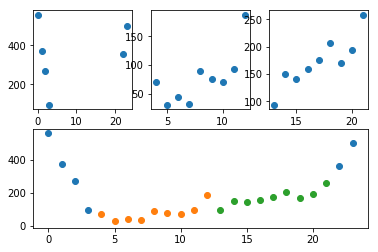

In [45]:
plt.ylabel('Count of Crime')
plt.ylabel('Hour')
plt.subplot(231)
plt.scatter(period1_count["Hour"].astype(int),period1_count["Count of Crime"]) 
plt.subplot(232)
plt.scatter(period2_count["Hour"].astype(int),period2_count["Count of Crime"]) 
plt.subplot(233)
plt.scatter(period3_count["Hour"].astype(int),period3_count["Count of Crime"]) 
plt.subplot(212)
plt.scatter(period1_count["Hour"].astype(int),period1_count["Count of Crime"]) 
plt.scatter(period2_count["Hour"].astype(int),period2_count["Count of Crime"])
plt.scatter(period3_count["Hour"].astype(int),period3_count["Count of Crime"]) 

# Crime types in various time periods

In [46]:
# This is a visualization of the number of incidents regarding the crime categories.

In [47]:
Morning = crime_type_sort(result1["Crime Description"])
Afternoon = crime_type_sort(result2["Crime Description"])
Night = crime_type_sort(result3["Crime Description"])

In [48]:
crime_cpy = time_crime
for i in range(len(crime_cpy['Crime Description'])):
    if len(re.findall(crime_1,crime_cpy['Crime Description'][i])) >= 1:
        crime_cpy['Crime Description'][i] = 'alcohol_related'
    if len(re.findall(crime_2,crime_cpy['Crime Description'][i])) >= 1:
        crime_cpy['Crime Description'][i] = 'property_related'
    if len(re.findall(crime_3,crime_cpy['Crime Description'][i])) >= 1:
        crime_cpy['Crime Description'][i] = 'drugs_related'
    if len(re.findall(crime_4,crime_cpy['Crime Description'][i])) >= 1:
        crime_cpy['Crime Description'][i] = 'violence_related'
    if len(re.findall(crime_5,crime_cpy['Crime Description'][i])) >= 1:
        crime_cpy['Crime Description'][i] = 'sexual_related'
    if len(re.findall(crime_6,crime_cpy['Crime Description'][i])) >= 1:
        crime_cpy['Crime Description'][i] = 'harassment_related'
    if len(re.findall(crime_7,crime_cpy['Crime Description'][i])) >= 1:
        crime_cpy['Crime Description'][i] = 'suicide'
    if len(re.findall(crime_8,crime_cpy['Crime Description'][i])) >= 1:
        crime_cpy['Crime Description'][i] = 'weapon_related'
    if len(re.findall(crime_9,crime_cpy['Crime Description'][i])) >= 1:
        crime_cpy['Crime Description'][i] = 'id_related'

In [49]:
crime_type = ['alcohol_related','property_related','drugs_related',
              'violence_related','sexual_related','harassment_related',
              'suicide','weapon_related','id_related']
colors = ['#e6194b','#3cb44b','#ffe119','#0082c8','#f58231',
         '#911eb4','#46f0f0','#f032e6','#ffd8b1']
explode = (0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02)

In [50]:
@ipywidgets.interact(
                    Time = ['Morning 3:00 - 12:00', 
                             'Afternoon 12:00 - 21:00', 
                             'Night 21:00 - 3:00'])
def print_bar_plot(Time):
    if Time == 'Morning 3:00 - 12:00':
        y_data = Morning
    if Time == 'Afternoon 12:00 - 21:00':
        y_data = Afternoon
    if Time == 'Night 21:00 - 3:00': 
        y_data = Night
        
    x_sc = OrdinalScale()
    y_sc = LinearScale()
    x_data = crime_type
    
    bar_chart = Bars(x = x_data, y = y_data, 
                     interactions={'click': 'select','hover': 'tooltip',},
                     unselected_style = {"opacity": "0.5"},
                     selected_style = {"opacity": "1",'fill': '#ffd8b1'},
                     scales={'x': x_sc, 'y': y_sc})
    ax_x = Axis(scale=x_sc)
    ax_y = Axis(scale=y_sc, orientation='vertical')

    def_tt = Tooltip(fields=['x', 'y'], formats=['', 'd'])
    bar_chart.tooltip=def_tt
    fig = Figure(marks=[bar_chart],title='Frenquency of crimes in different time')
    display(fig)

interactive(children=(Dropdown(description='Time', options=('Morning 3:00 - 12:00', 'Afternoon 12:00 - 21:00', 'Night 21:00 - 3:00'), value='Morning 3:00 - 12:00'), Output()), _dom_classes=('widget-interact',))

In [51]:
# This is a visualization of the components of the crime types in different time periods.

In [52]:
@ipywidgets.interact(Time = ['Morning 3:00 - 12:00', 
                             'Afternoon 12:00 - 21:00', 
                             'Night 21:00 - 3:00'])
def print_pie_chart(Time): 
    if Time == 'Morning 3:00 - 12:00':
        pie_data = np.array(Morning)/sum(Morning)
    if Time == 'Afternoon 12:00 - 21:00':
        pie_data = np.array(Afternoon)/sum(Afternoon)
    if Time == 'Night 21:00 - 3:00':
        pie_data = np.array(Night)/sum(Night)
#     pie_data = Morning
    sc = ColorScale(scheme='Reds')
    tooltip_widget = Tooltip(fields=['size'], formats=['0.2f'])
    pie = Pie(sizes = pie_data,display_labels='outside',  color = np.random.randn(9), 
              tooltip = tooltip_widget, interactions = {'click': 'tooltip'}, 
              selected_style = {'fill': 'red'})

    pie.selected_style = {"opacity": "1", "stroke": "white", "stroke-width": "2"}
    pie.unselected_style = {"opacity": "0.4"}
    pie.interactions = {'click': 'select', 'hover': 'tooltip'}
    pie.labels = list(crime_type)
    fig = Figure(marks=[pie],title='Incident distribution in different time')
    display(fig)

interactive(children=(Dropdown(description='Time', options=('Morning 3:00 - 12:00', 'Afternoon 12:00 - 21:00', 'Night 21:00 - 3:00'), value='Morning 3:00 - 12:00'), Output()), _dom_classes=('widget-interact',))

In [53]:
import plotly
import plotly.plotly as py
from plotly.graph_objs import *
mapbox_access_token = 'pk.eyJ1IjoiY2hhb2hhbnNoYW5nIiwiYSI6ImNqZ21kcHZtcjAwbXIzMm8zcWo0dXhtdHAifQ.lb2gdvCkcLPqk5JykhY9Fg'

data = Data([
    Scattermapbox(
        lat=['40.1100049','40.10393699999999',
             '40.108267','40.109713',
             '40.1080694','40.1092101',
             '40.109711','40.1041097'],
        lon=['-88.23565919999999','-88.235277',
             '-88.2292304','-88.23178289999998',
             '-88.22953769999998','-88.22722249999998',
             '-88.230235','-88.22085049999998'],
        mode='markers',
        marker=Marker(
            color = 'rgb(0,116,217)',
            size=9
        ),
        text=["RED LION: 281","SDRP: 81",
              "ILLINI UNION BOOKSTOR: 70","JOE'S BREWERY: 62",
              "KAMS: 59","ILLINI UNION: 55",
              "CLYBOURNE: 53","ALLEN RESIDENCE HALL: 49"],
    )
])
layout = Layout(
    autosize=True,
    hovermode='closest',
    mapbox=dict(
        accesstoken=mapbox_access_token,
        bearing=0,
        center=dict(
            lat=40.108267,
            lon=-88.2292304
        ),
        pitch=0,
        zoom=14
    ),
)

fig = dict(data=data, layout=layout)
py.iplot(fig, filename='Multiple Mapbox')

NameError: name 'Data' is not defined